In [1]:
# Import required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from matplotlib.pyplot import figure, show
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import mean_squared_error

In [2]:
# Creating names for columns, read the dataset using pandas dataframe and replacing all null values with '?'

In [3]:
# Creating a list for column names
names = ['index','injury_date','player_code', 'name', 'description', 'sport', 
         'weight','height', 'age','days_to_play', 'injury_year', 'injury_month']

test_file = open('./input/all.csv')
for line in test_file:
    print(line.strip())

In [13]:
df = pd.read_csv("./input/all.csv", na_values=['?'], 
     names = names)

In [14]:
# Checking, if all the column names are added correctly
df.columns

Index(['index', 'injury_date', 'player_code', 'name', 'description', 'sport',
       'weight', 'height', 'age', 'days_to_play', 'injury_year',
       'injury_month'],
      dtype='object')

In [15]:
# We don't require time series data for this model, thus dropping injury_date from the dataframe, 
# also other coloums not suitable for this study 
df.drop(['injury_date'], 1, inplace=True)
df.drop(['injury_year'], 1, inplace=True)
df.drop(['index'], 1, inplace=True)
df.drop(['name'], 1, inplace=True)
df.drop(['player_code'], 1, inplace=True)

In [16]:
# In the dataset for the sport basketball, bball has been recorded, which sometimes confuses. 
# Thus we will change all the occurance of bball to basketball.
df['sport'] = df['sport'].replace ({'bball':'basketball'})

In [17]:
# print the top 5 rows of the dataset
df.head()

,description,sport,weight,height,age,days_to_play,injury_month
0,torn ligament in left thumb,basketball,81.0,220.0,23,10,10
1,placed on IR with back strain,basketball,82.0,227.0,22,36,11
2,placed on IL with left elbow bursitis,basketball,73.0,180.0,24,11,1
3,placed on IL with left ankle tendinitis,basketball,73.0,180.0,23,14,11
4,placed on IL with bruised left shoulder,basketball,73.0,180.0,24,10,4


In [18]:
#Checking data types of all the features
df.dtypes

description      object
sport            object
weight          float64
height          float64
age               int64
days_to_play      int64
injury_month      int64
dtype: object

# Features Data types:
Since the data types are not correct for all the features, changing to appropriate data types

In [19]:
df["description"] = df["description"].astype('category')
df["sport"] = df["sport"].astype('category')
df["weight"] = df["weight"].astype('float')
df["height"] = df["height"].astype('float')
df["age"] = df["age"].astype('float')
df["days_to_play"] = df["days_to_play"].astype('float')
df["injury_month"] = df["injury_month"].astype('category')

In [20]:
# Show all the statistical measures of the data set using describe function
df.describe()

,weight,height,age,days_to_play
count,69247.000000,69253.000000,69254.000000,69254.000000
mean,76.305587,220.014714,27.785500,99.495495
std,4.172740,31.479919,5.372872,347.626770
min,64.000000,135.000000,-10.000000,0.000000
25%,73.000000,198.000000,24.000000,4.000000
50%,76.000000,215.000000,27.000000,14.000000
75%,80.000000,235.000000,31.000000,59.000000
max,91.000000,375.000000,157.000000,11797.000000


The above table confirms presence of missing values and also some outliers, 
as maximum age of 157 years is an impossible value. 11797 days also can be considered as outlier.

In [21]:
# Checking if any null values present in the dataframe
df.isna().sum()

description     2
sport           0
weight          7
height          1
age             0
days_to_play    0
injury_month    0
dtype: int64

Features with non zero values, represents missing values. Which means description, weight and height have some missing values.
Since missing values are very low in numbers, it is safe to drop all null values, if present.

In [22]:
df.dropna(inplace = True)

# Feature extraction:


In [23]:
#convert description column to lower case to process the data
df['description'] = df['description'].str.lower()

The following operations are performed to seperate body parts and injury types from the Description column. 
Also, some bodyparts are recored with different names like abdomen is recorded as appendectomy, 
appendicitis and abdominal. This code replaces mentioned multiple body parts, which has same meaning to uniform body part, 
for example if the word appendectomy found, the code replaces the word with abdomen 

In [24]:
df['description'] = df['description'].replace ({'appendectomy':'abdomen', 
'appendicitis': 'abdomen', 'abdominal':'abdomen','hernia': 'stomach', 
'concussion':'brain', 'corneal':'eye', 'respiratory':'lung', 
'gastrocnemius':'calf', 'gastrointestinal': 'stomach',  
'thrombocytopenia':'blood disorder', 'dental': 'tooth', 
'double vision' :'eye' , 'oral surgery': 'mouth', 'osteitis pubis':'pubic', 
'tonsilitis': 'throat','lumber spine' : 'spine', 'facial' : 'face' })


In [25]:
# Below is function to find the match, which expects a string value and compare the value with given list.
def search_pattern(s, bodyparts):
    found_bodyparts = [bodypart for bodypart in bodyparts if bodypart in s]
    if len(found_bodyparts)==1:
        return ', '.join(found_bodyparts)
    else:
        return None


In [26]:
# List, for all possible names of body parts and injury types, observed from the dataset
bodyparts = ['thumb', 'back', 'elbow', 'shoulder', 'ankle', 'knee', 'achilles', 
             'arm', 'arthoscopic', 'bicep','calf', 'cervical', 'chest', 
             'collarbone', 'eye', 'facial', 'fibula', 'finger', 'foot', 
             'forearm', 'flexor', 'groin', 'hand', 'hamstring', 'head', 
             'heel', 'hip', 'jaw', 'leg', 'mouth', 'meniscus',
             'neck', 'nose', 'oblique', 'pectoral', 'quadricep', 'rib','ribcage',
             'shin', 'sinus','stomach', 'thigh', 'toe', 'triceps', 'wrist', 
             'throat', 'tibia','tailbone', 'tooth', 'rotator cuff', 'appendix',
             'kidney', 'lung','cheekbone','pelvis',  'patellar', 'heart',
              'patella', 'spine']


injurytype = ['torn','virus','stiff','sprain','spasm','surgery','sore',
              'rupture','pulled','flu','plantar_fasciitis','lacerate',
              'harnia', 'inflammation', 'infection', 'illness','fractured',
              'food_poisoning','cramp','dizziness', 'concussion', 'strain', 
              'bursitis','tendinitis','ailment',  'appendectomy', 
              'broken','bruise' ]

In [27]:
# Now we will apply search pattern function to create seperate columns to body part and injury type
df['bodyparts'] = df['description'].apply(lambda x : search_pattern(x, bodyparts))
df['injury_type'] = df['description'].apply(lambda x : search_pattern(x, injurytype))
df["bodyparts"] = df["bodyparts"].astype('category')
df["injury_type"] = df["injury_type"].astype('category')
df.drop(['description'], 1, inplace=True)
df.dropna(inplace = True)

In [28]:
# n order to improve the correlation between feature 'height' and 'weight' and the target variable. 
# Here is the function to calculate BMI index, from heights and weights of the players, as part of feature reduction
def convert_into_BMI (w, h_cm):
    h_m = h_cm/100
    BMI = w/(h_m*h_m)
    return BMI
df['BMI'] = convert_into_BMI(df['weight'], df['height'])

# Remove Outliers: 
The below code removes outliers from the dataset outside of 1.5 standard deviation, which I have 
used to remove outliers from feature 'age', 'days_to_play' and 'BMI'.

In [29]:
def reject_outliers(data):
    u = np.mean(data)
    s = np.std(data)
    f1 = u - 1.5*s
    f2 = u + 1.5*s
    filtered = np.where(data.between(f1,f2),data, data.median())
    return filtered

df['days_replaced'] = reject_outliers(df['days_to_play'])
df['age'] = reject_outliers(df['age'])
df['BMI'] = reject_outliers(df['BMI'])
df['height'] = reject_outliers(df['height'])
df['weight'] = reject_outliers(df['weight'])
df.drop(['days_to_play'], 1, inplace=True)

# Data insights using pandas dataframe (added after phase 1)

In [30]:
# Avg days to return to the sport for all bodyparts injury 
df_agg_bodyparts = df.groupby( 'bodyparts').agg(np.mean).round().sort_values("days_replaced", ascending=False).reset_index()

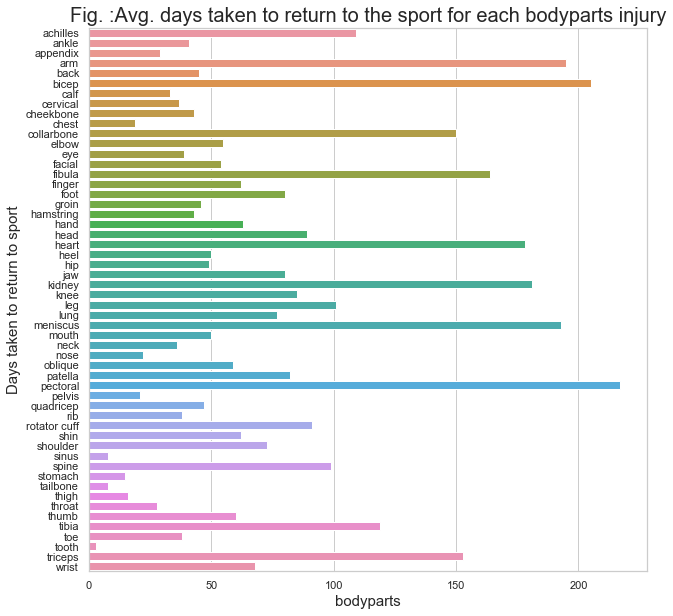

In [31]:
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10,10))
ax = sns.barplot(y="bodyparts", x="days_replaced", data=df_agg_bodyparts)
plt.xlabel('bodyparts', fontsize=15)
plt.ylabel('Days taken to return to sport', fontsize=15)
plt.title('Fig. :Avg. days taken to return to the sport for each bodyparts injury', fontsize=20)
plt.show()

In [32]:
# Top 5 bodyparts injury, taking longest to return to sport hockey, baseball, basketball and football
df_agg_sports = df.groupby(['sport', 'bodyparts']).first().round().sort_values('days_replaced', ascending=False).sort_index(level=[0], ascending=[True])
df_agg_sports.iloc[df_agg_sports.index.get_level_values('sport') == 'hockey'].sort_values('days_replaced', ascending=False).sort_index(level=[0], ascending=[True]).head()

BMI   age  days_replaced  height  weight
sport  bodyparts                                           
hockey shoulder   16.0  26.0          413.0   215.0    72.0
       meniscus   21.0  24.0          238.0   184.0    78.0
       ankle      15.0  28.0          216.0   220.0    74.0
       neck       16.0  21.0          197.0   216.0    76.0
       pectoral   21.0  28.0          193.0   182.0    78.0

In [33]:
# Most time taking bodyparts for baseball
df_agg_sports.iloc[df_agg_sports.index.get_level_values('sport') == 'baseball'].head()

BMI   age  days_replaced  height  weight
sport    bodyparts                                           
baseball nose       16.0  29.0          443.0   210.0    72.0
         ankle      16.0  25.0          353.0   210.0    78.0
         arm        16.0  33.0          339.0   215.0    75.0
         achilles   19.0  26.0          333.0   195.0    72.0
         elbow      17.0  26.0          319.0   205.0    73.0

In [34]:
# Most time taking bodyparts for basketball
df_agg_sports.iloc[df_agg_sports.index.get_level_values('sport') == 'basketball'].head()

BMI   age  days_replaced  height  weight
sport      bodyparts                                           
basketball leg        18.0  34.0          423.0   208.0    77.0
           heart      12.0  29.0          384.0   256.0    81.0
           kidney     14.0  33.0          321.0   240.0    82.0
           triceps    12.0  28.0          280.0   252.0    78.0
           facial     15.0  26.0          203.0   235.0    83.0

In [35]:
# Most time taking bodyparts for football
df_agg_sports.iloc[df_agg_sports.index.get_level_values('sport') == 'football'].head()

BMI   age  days_replaced  height  weight
sport    bodyparts                                              
football arm           17.0  24.0          521.0   218.0    78.0
         achilles      13.0  27.0          416.0   244.0    77.0
         cervical      13.0  26.0          369.0   240.0    76.0
         foot          15.0  23.0          355.0   223.0    74.0
         rotator cuff  15.0  29.0          349.0   225.0    75.0

In [36]:
# Avg. days taken to return to the sport for each injury type

In [37]:
df_agg_injury_type = df.groupby( 'injury_type').agg(np.mean).round().sort_values("days_replaced", ascending=False).reset_index().head()

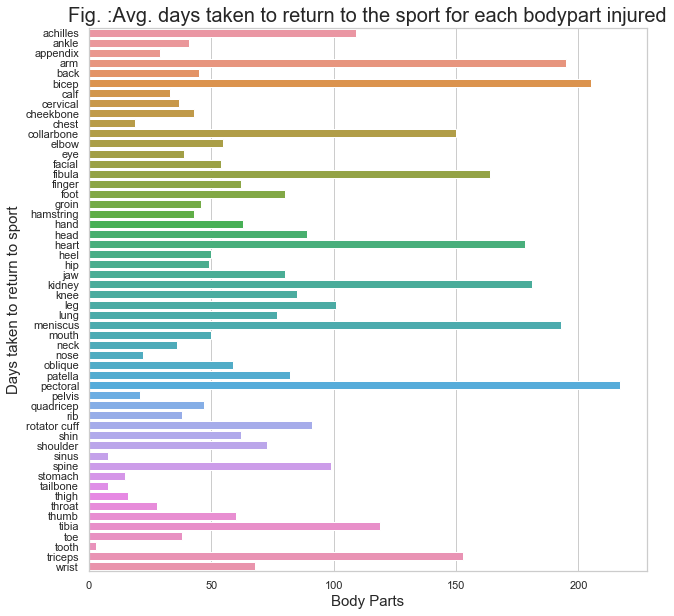

In [38]:
#sns.set(style="whitegrid")
plt.figure(figsize=(10,10))
ax = sns.barplot(y="bodyparts", x="days_replaced", data=df_agg_bodyparts)
plt.xlabel('Body Parts', fontsize=15)
plt.ylabel('Days taken to return to sport', fontsize=15)
plt.title('Fig. :Avg. days taken to return to the sport for each bodypart injured', fontsize=20)
plt.show()


# Data Encoding using one-hot coding

Since some algorithms accepts only numeric values from the feature, thus one hot coding will create numerical values for all the categorical columns and since our target variable is a float datatype, we can do one hot coding before spliting into feature and target, as get_dummies will only code categorical variables.

In [39]:
df = pd.get_dummies(df)

In [40]:
# Check the dataframe and columns

In [41]:
print(df.head())

   weight  height   age        BMI  days_replaced  sport_baseball  \
0    81.0   220.0  23.0  16.735537           10.0               0   
1    82.0   227.0  22.0  15.913369           36.0               0   
2    73.0   180.0  24.0  16.680219           11.0               0   
3    73.0   180.0  23.0  16.680219           14.0               0   
4    73.0   180.0  24.0  16.680219           10.0               0   

   sport_basketball  sport_football  sport_hockey  injury_month_1  ...  \
0                 1               0             0               0  ...   
1                 1               0             0               0  ...   
2                 1               0             0               1  ...   
3                 1               0             0               0  ...   
4                 1               0             0               0  ...   

   injury_type_rupture  injury_type_sore  injury_type_spasm  \
0                    0                 0                  0   
1             

In [42]:
print(df.columns)

Index(['weight', 'height', 'age', 'BMI', 'days_replaced', 'sport_baseball',
       'sport_basketball', 'sport_football', 'sport_hockey', 'injury_month_1',
       'injury_month_2', 'injury_month_3', 'injury_month_4', 'injury_month_5',
       'injury_month_6', 'injury_month_7', 'injury_month_8', 'injury_month_9',
       'injury_month_10', 'injury_month_11', 'injury_month_12',
       'bodyparts_achilles', 'bodyparts_ankle', 'bodyparts_appendix',
       'bodyparts_arm', 'bodyparts_back', 'bodyparts_bicep', 'bodyparts_calf',
       'bodyparts_cervical', 'bodyparts_cheekbone', 'bodyparts_chest',
       'bodyparts_collarbone', 'bodyparts_elbow', 'bodyparts_eye',
       'bodyparts_facial', 'bodyparts_fibula', 'bodyparts_finger',
       'bodyparts_foot', 'bodyparts_groin', 'bodyparts_hamstring',
       'bodyparts_hand', 'bodyparts_head', 'bodyparts_heart', 'bodyparts_heel',
       'bodyparts_hip', 'bodyparts_jaw', 'bodyparts_kidney', 'bodyparts_knee',
       'bodyparts_leg', 'bodyparts_lung', '

# Split data into features and target

Now, the dataframe is ready to be splitted into feature and target. For this study days take to return to the sport is our target variable which is days_replaced, rest other variables are our features dataframe. Since, the target variable is poisson variable, we will perform the log tranformation and assign it as target.

In [43]:
features = df.drop(columns = 'days_replaced')
target = np.log10(df['days_replaced'])

With some exploration, -inf values have been identified in the series, below code will remove all -inf values and zero's and replace with mean.

In [44]:
target[target==-np.inf]=np.nan
target.fillna(target.mean(), inplace=True)
target.replace(0.0, target.mean(), inplace = True)

# Normalization using standard scaler

In [45]:
# scaling the features using standard scaler
scaler = preprocessing.StandardScaler()
features_scaled = scaler.fit_transform(features)

Now, we will perform feature selection and find out most relevant feature for the target variable. For this task we will use f score and random forest importance metric for feature selection.

# Feature Selection using fscore

In [46]:
from sklearn import feature_selection as fs
fs_fit_fscore = fs.SelectKBest(fs.f_regression, k=10)
fs_fit_fscore.fit_transform(features_scaled, target)
fs_indices_fscore = np.argsort(fs_fit_fscore.scores_)[::-1][0:10]
fs_indices_fscore

array([ 6, 95, 97,  5, 92, 83, 46, 77, 76, 11], dtype=int64)

In [47]:
feature_importances_fscore = fs_fit_fscore.scores_[fs_indices_fscore]
feature_importances_fscore

array([2280.87441184, 1980.31539955, 1613.7635175 ,  980.70018674,
        585.02468149,  498.52907148,  416.48260073,  409.16302171,
        378.48410455,  368.39690575])

In [48]:
best_features__ = features.columns[fs_indices_fscore].values
best_features__

array(['sport_football', 'injury_type_surgery', 'injury_type_torn',
       'sport_basketball', 'injury_type_sprain', 'injury_type_fractured',
       'bodyparts_knee', 'injury_type_bruise', 'injury_type_broken',
       'injury_month_4'], dtype=object)

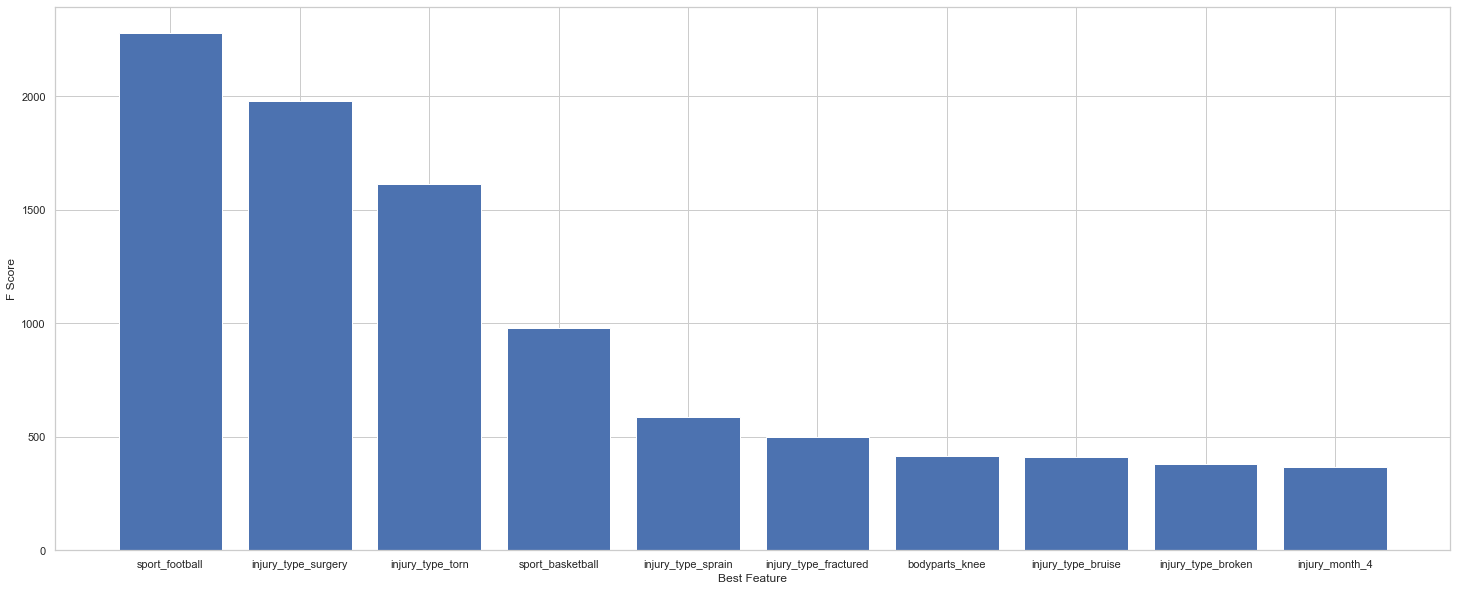

In [49]:
# plot top 10 features
plt.rc('figure', figsize=(25.0, 10.0))
plt.bar(range(len(fs_fit_fscore.scores_[fs_indices_fscore])), 
        fs_fit_fscore.scores_[fs_indices_fscore])
plt.xticks(np.arange(10), (best_features__))
plt.tick_params(labelsize=11)
plt.ylabel('F Score')
plt.xlabel('Best Feature')
plt.show()

# Feature selection using Random Forest Importance method

Thus, we can see that most relevant feature f score suggests are above features in order of high to low. 

In [50]:
# Building model to return 10 best features
from sklearn.ensemble import RandomForestRegressor
num_features = 10
model_rfi = RandomForestRegressor(n_estimators=10)
model_rfi.fit(features_scaled, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

In [51]:
# Importance score
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importances_rfi

array([0.14155383, 0.12477944, 0.0869336 , 0.0855575 , 0.0841258 ,
       0.0710725 , 0.03534106, 0.02872176, 0.02275938, 0.01952418])

In [52]:
# Feature names
best_features_rfi = features.columns[fs_indices_rfi].values
best_features_rfi

array(['BMI', 'age', 'height', 'sport_football', 'weight',
       'injury_type_surgery', 'injury_type_torn', 'injury_month_4',
       'injury_type_fractured', 'injury_type_broken'], dtype=object)

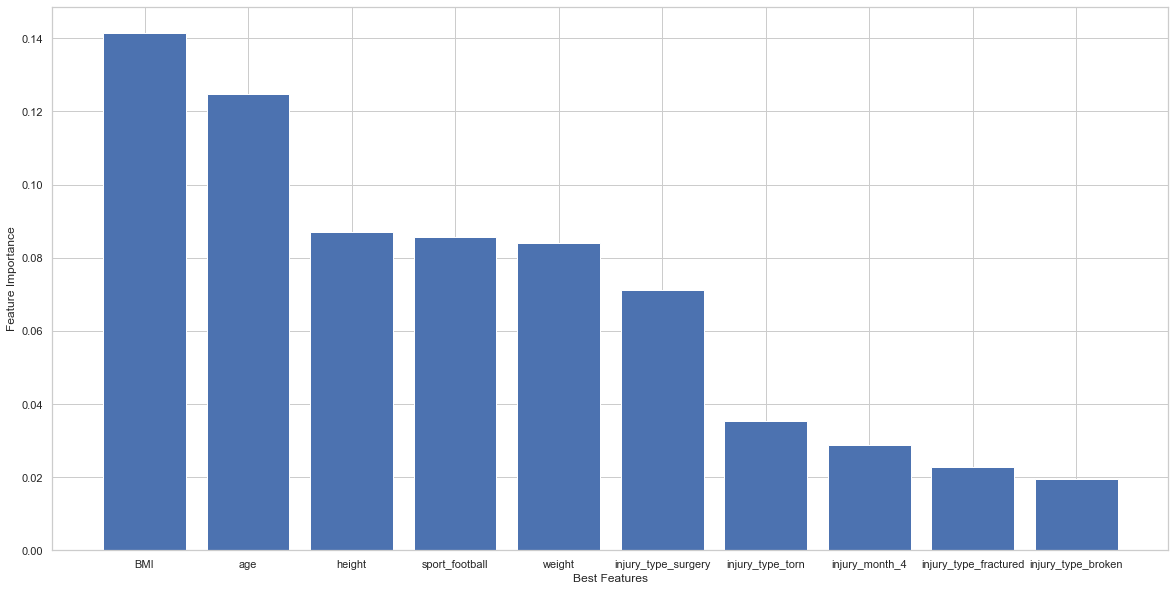

In [53]:
# plot top 10 features 
plt.rc('figure', figsize=(20.0, 10.0))
plt.bar(range(len(model_rfi.feature_importances_[fs_indices_rfi])), 
        model_rfi.feature_importances_[fs_indices_rfi])
plt.xticks(np.arange(10), (best_features_rfi))
plt.tick_params(labelsize=11)
plt.ylabel('Feature Importance')
plt.xlabel('Best Features')

plt.show()

Thus, we can see that most relevant feature RFI suggests are *'BMI', 'age', 'height', 'sport_football', 'weight', 'injury_type_surgery', 'injury_type_torn', 'injury_month_4','injury_type_fractured', 'injury_type_broken'* opposed to *'sport_football', 'injury_type_surgery', 'injury_type_torn','sport_basketball', 'injury_type_sprain', 'injury_type_fractured','bodyparts_knee', 'injury_type_bruise', 'injury_type_broken','injury_month_4'*suggested by fscore. Interestingly, RFI chooses BMI as most relevant where as with f score it was sport_football.

# Feature selection using the Built-in XGBoost Feature Importance Method

In [54]:
# plot feature importance using built-in function
from xgboost import XGBRegressor
model_xgb = XGBRegressor()
model_xgb.fit(features_scaled, target)

# feature importance
fs_indices_xgb = np.argsort(model_xgb.feature_importances_)[::-1][0:num_features]
feature_importances_xgb = model_xgb.feature_importances_[fs_indices_xgb]
print(feature_importances_xgb)


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
best_features_xgb = features.columns[fs_indices_xgb].values
best_features_xgb

In [59]:
# plot top 10 features
plt.rc('figure', figsize=(20.0, 10.0))
plt.bar(range(len(model_xgb.feature_importances_[fs_indices_xgb])), 
        model_xgb.feature_importances_[fs_indices_xgb])
plt.xticks(np.arange(10), (best_features_xgb))
plt.tick_params(labelsize=10)
plt.ylabel('Feature Importance')
plt.xlabel('Best Features')
plt.show()



NameError: name 'model_xgb' is not defined

Feature importance showed by XGB, shows same features as f score feature importance, which is Spoert_football as best feature.

# Data Sampling

Generally for larger dataset, computational time is very high, specially when performing hyperparameter tuning, thus we will take a sample of 10000 observation to perform grid search.

In [60]:
# sample size
print('total_data_shape :', df.shape)
n_samples = 15000
print('sample Taken:',n_samples)
features_scaled_sample = pd.DataFrame(features_scaled).sample(n=n_samples, random_state=1).values
target_sample = pd.DataFrame(target).sample(n=n_samples, random_state=1).values

print("Feature's Shape: " ,features_scaled_sample.shape)
print ("target's Shape: ", target_sample.shape)


total_data_shape : (25345, 100)
sample Taken: 15000
Feature's Shape:  (15000, 99)
target's Shape:  (15000, 1)


# Train test split

In [61]:
#spliting the training and testing data, keeping 20% for testing and rest for training. 
from sklearn.model_selection import train_test_split
features_scaled_sample_train, features_scaled_sample_test, target_sample_train, target_sample_test = train_test_split(features_scaled_sample, target_sample, test_size = 0.20, random_state = 42) 

# Hyperparameter tuning using Grid Search and using pipeline 

Custom class for random forest importance, courtesy to Vural for providing the code in sample report.

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin

# custom function for RFI feature selection inside a pipeline
# here we use n_estimators=100
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    
    # class constructor 
    # make sure class attributes end with a "_"
    # per scikit-learn convention to avoid errors
    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    # override the fit function
    def fit(self, X, y):
        from sklearn.ensemble import RandomForestRegressor
        from numpy import argsort
        model_rfi = RandomForestRegressor(n_estimators=100)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 
    
    # override the transform function
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]

# Grid search for finding best parameters for Decision Tree Regressor

In [ ]:
# Before starting grid search, we will create a list to store all the cross validated RMSE, which we will plot for model comparision and 
# after every resion we will append the result into that list
RMSE_Results = []

Now we will do hyperparameter tuning for Decision Tree Regressor, where we will pass feature selection using Random forest importance with features 5, 6 and all 99 features, followed by max depth from 1 to 10 and min sample split of 2 and 5. For scoring, we will use mean squared error.

In [55]:
# Now we will do hyperparameter tuning for decision tree, where we will pass feature selection using Random forest importance with features 5, 6 and all 9 features, followed by max depth of 3,4,5 and min sample split of 2 and 5.from sklearn.tree import DecisionTreeRegressor

pipe_DT = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('dt', DecisionTreeRegressor())])

depths = np.arange(1, 10)

params_pipe_DT = {'rfi_fs__n_features_': [5, 6, features_scaled_sample.shape[1]],
                  'dt__max_depth': depths,
                  'dt__min_samples_split': [2, 5]}

gs_pipe_DT = GridSearchCV(estimator=pipe_DT, 
                          param_grid=params_pipe_DT, 
                          cv=5,
                          refit=True,
                          n_jobs=-1,
                          scoring='neg_mean_squared_error',
                          verbose=1) 

gs_pipe_DT.fit(features_scaled_sample_train, target_sample_train);

NameError: name 'RFIFeatureSelector' is not defined

In [56]:
# Grid search has returned following best paramenters and score
print(gs_pipe_DT.best_params_)
print(gs_pipe_DT.best_score_)

NameError: name 'gs_pipe_DT' is not defined

In [57]:
# Ensuring RMSE, using cross validation
from sklearn.model_selection import cross_val_score
cv_results_DT = np.sqrt(-cross_val_score(gs_pipe_DT, features_scaled_sample, target_sample, scoring='neg_mean_squared_error'))
print("RMSE: %0.2f (+/- %0.2f)" % (cv_results_DT.mean(), cv_results_DT.std() * 2))
RMSE_Results.append(cv_results_DT.mean())

NameError: name 'gs_pipe_DT' is not defined

# Grid search for finding best parameters for Random Forest Regressor

Now we will do hyperparameter tuning for random forest regressor, where we will pass feature selection using Random forest importance with features 5, 6 and all 99 features, followed by max depth 9 and 10 and min sample split of 2 and 5. For scoring, we will use mean squared error.

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


rf_regressor = RandomForestRegressor(random_state=999)

pipe_RF = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('rf', rf_regressor)])



params_pipe_RF = {'rfi_fs__n_features_': [5, 6, features_scaled.shape[1]],                  
                  'rf__max_depth': [9,10], 
                  'rf__min_samples_split': [2, 5]}
 
    


gs_pipe_RF  = GridSearchCV(estimator=pipe_RF, 
                           param_grid=params_pipe_RF, 
                           cv=5,
                           n_jobs=-1,
                           scoring= 'neg_mean_squared_error', 
                           verbose=1)

gs_pipe_RF.fit(features_scaled_sample_train, target_sample_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.7min finished


In [64]:
# Grid search has returned following best paramenters and score
print('Best Grid Score:', gs_pipe_RF.best_score_)
print('Best Parameters:', gs_pipe_RF.best_params_)

Best Grid Score: -0.33275149162004475
Best Parameters: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rfi_fs__n_features_': 99}


In [65]:
# Ensuring RMSE, using cross validation
cv_results_RF = np.sqrt(-cross_val_score(gs_pipe_RF, features_scaled_sample, target_sample, scoring='neg_mean_squared_error'))
print("RMSE: %0.2f (+/- %0.2f)" % (cv_results_RF.mean(), cv_results_RF.std() * 2))
RMSE_Results.append(cv_results_RF.mean())

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.5min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.5min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.5min finished


RMSE: 0.58 (+/- 0.01)


NameError: name 'RMSE_Results' is not defined

# Grid search for finding best parameters for K Nearest Neigbors Regressor

After random forest regressor, we will try another very popular machine learning algorithnm KNN, but before we will again scale features with MIn-Max scaler, where we will pass all similar parameters as above regressor and neighbours 8 and 10. For scoring, we will use mean squared error.
.

In [58]:
# Before buidling KNN model, lets scale using Min-Max scaler, as earlier we used standard scaler for normalization
# scaling the features using standard scaler, followed by data sampling and splitting into train test arrays
scaler = preprocessing.MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [59]:
# sample size
print('total_data :', df.shape)
n_samples = 15000
print('sample Taken:',n_samples)
features_scaled_sample = pd.DataFrame(features_scaled).sample(n=n_samples, random_state=1).values
target_sample = pd.DataFrame(target).sample(n=n_samples, random_state=1).values

print("Feature's Shape: " ,features_scaled_sample.shape)
print ("target's Shape: ", target_sample.shape)

total_data : (25345, 100)
sample Taken: 15000
Feature's Shape:  (15000, 99)
target's Shape:  (15000, 1)


In [66]:
#spliting the training and testing data, keeping 20% for testing and rest for training. 
features_scaled_sample_train, features_scaled_sample_test, target_sample_train, target_sample_test = train_test_split(features_scaled_sample, target_sample, test_size = 0.20, random_state = 42)

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

pipe_KNN = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                           ('knn', KNeighborsRegressor())])



params_pipe_KNN = {'rfi_fs__n_features_': [5, 6, features_scaled.shape[1]],
                   'knn__n_neighbors': [8,10],
                   'knn__p': [1, 2]}

gs_pipe_KNN = GridSearchCV(estimator=pipe_KNN, 
                           param_grid=params_pipe_KNN, 
                           cv=5,
                           refit=True,
                           n_jobs=-1,
                           scoring='neg_mean_squared_error',
                           verbose=1) 
gs_pipe_KNN.fit(features_scaled_sample_train, target_sample_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.0min finished


In [68]:
# Grid search has returned following best paramenters and score
print('Best Grid Score:', gs_pipe_KNN.best_score_)
print('Best Parameters:', gs_pipe_KNN.best_params_)

Best Grid Score: -0.3423509877801501
Best Parameters: {'knn__n_neighbors': 10, 'knn__p': 1, 'rfi_fs__n_features_': 99}


In [63]:
# Ensuring RMSE, using cross validation
cv_results_KNN = np.sqrt(-cross_val_score(gs_pipe_KNN, features_scaled_sample, target_sample, scoring='neg_mean_squared_error'))
print("RMSE: %0.2f (+/- %0.2f)" % (cv_results_KNN.mean(), cv_results_KNN.std() * 2))
RMSE_Results.append(cv_results_KNN.mean())

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.8min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.9min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.0min finished


RMSE: 0.58 (+/- 0.01)


# Regression with Gradient Boosting Regressor

Next, we will build Regression Gradient Boosting Regressor and passing parameters

In [64]:
from sklearn.ensemble import GradientBoostingRegressor
# set parameters for regression
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
model_gb = GradientBoostingRegressor(**params)
# Fit regression model
model_gb.fit(features_scaled_sample_train, target_sample_train)
rmse =np.sqrt( mean_squared_error(target_sample_test, model_gb.predict(features_scaled_sample_test)))
print("RMSE: %.4f" % rmse)

RMSE: 0.5794


In [65]:
# Ensuring RMSE, using cross validation
from sklearn.model_selection import cross_val_score
cv_results_GB = np.sqrt(-cross_val_score(model_gb, features_scaled_sample, target_sample, scoring='neg_mean_squared_error'))
print("RMSE: %0.2f (+/- %0.2f)" % (cv_results_GB.mean(), cv_results_GB.std() * 2))
RMSE_Results.append(cv_results_GB.mean())

RMSE: 0.58 (+/- 0.01)


# # Regression with XG Boost Regressor 

At last,as an experiment with ensemble technique, we will build regression model with XG Boost regressor, passing parameters.

In [66]:
# XG Boost model, which calculates RMSE 
import xgboost as xgb

data_dmatrix = xgb.DMatrix(data=features_scaled_sample,label=target_sample)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(features_scaled_sample_train, target_sample_train)

preds = xg_reg.predict(features_scaled_sample_test)

rmse = np.sqrt(mean_squared_error(target_sample_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.678761


In [67]:
# Ensuring RMSE, using cross validation
cv_results_XG = np.sqrt(-cross_val_score(xg_reg, features_scaled_sample, target_sample, scoring='neg_mean_squared_error'))
print("RMSE: %0.2f (+/- %0.2f)" % (cv_results_XG.mean(), cv_results_XG.std() * 2))
RMSE_Results.append((cv_results_XG).mean())

RMSE: 0.68 (+/- 0.01)


# Performance comparison

After all model parameter tuning, now we know which are the best parameters for all the regressors, Thus, we can now compare which will be the best regressor for this study, using t test, where we compare all the cross validation errors with each other.

                       Results
Decision Tree         0.595462
Random Forest         0.575133
K Nearest Neighbours  0.583498
Gradient Boosting     0.580861
XG Boost              0.682004


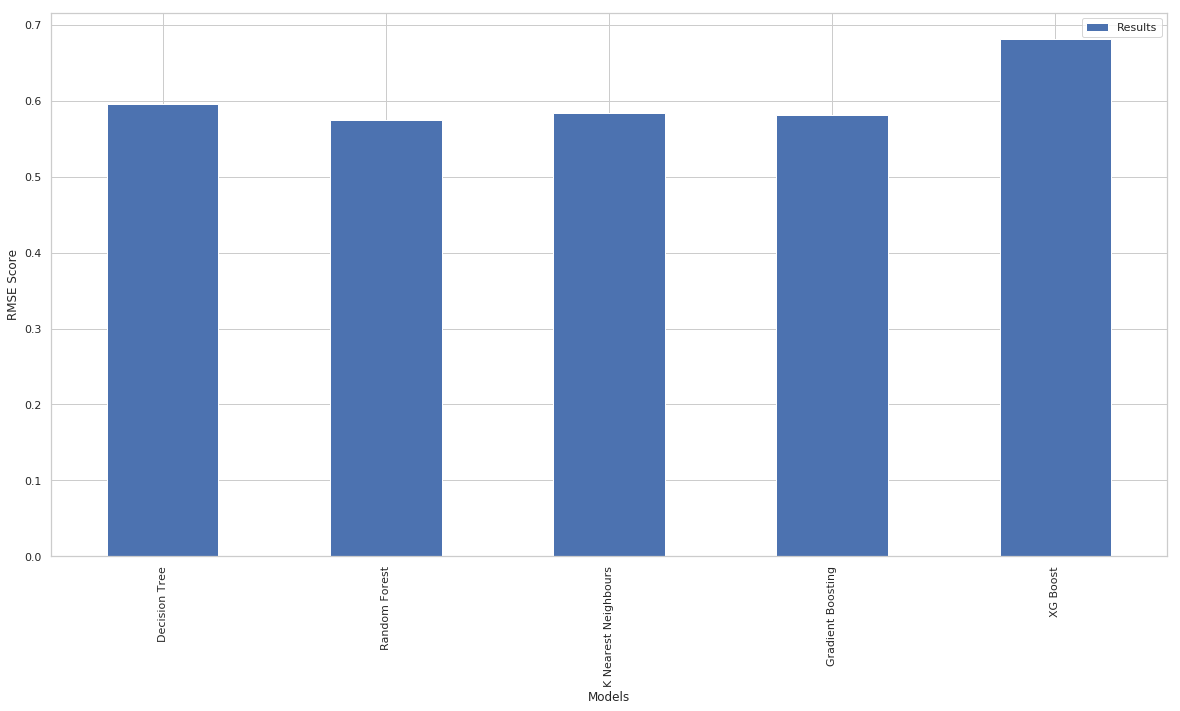

In [68]:
# creating datframe to compare results visually
# initialise data of lists. 

Regressors = ['Decision Tree', 'Random Forest', 'KNN', 'Gradient Boosting', 'XG Boost' ]  
RMSE_Results = [(cv_results_DT).mean(), (cv_results_RF).mean(), (cv_results_KNN).mean(), (cv_results_GB).mean(), (cv_results_XG).mean()]
data = {'Results':RMSE_Results } 
# Creates pandas DataFrame. 
df = pd.DataFrame(data, index = ['Decision Tree', 'Random Forest', 'K Nearest Neighbours', 'Gradient Boosting', 'XG Boost' ]) 

# print the data 
print(df)

# plot the dataframe
df.plot(kind = 'bar') 
plt.ylabel('RMSE Score')
plt.xlabel('Models')
plt.show()

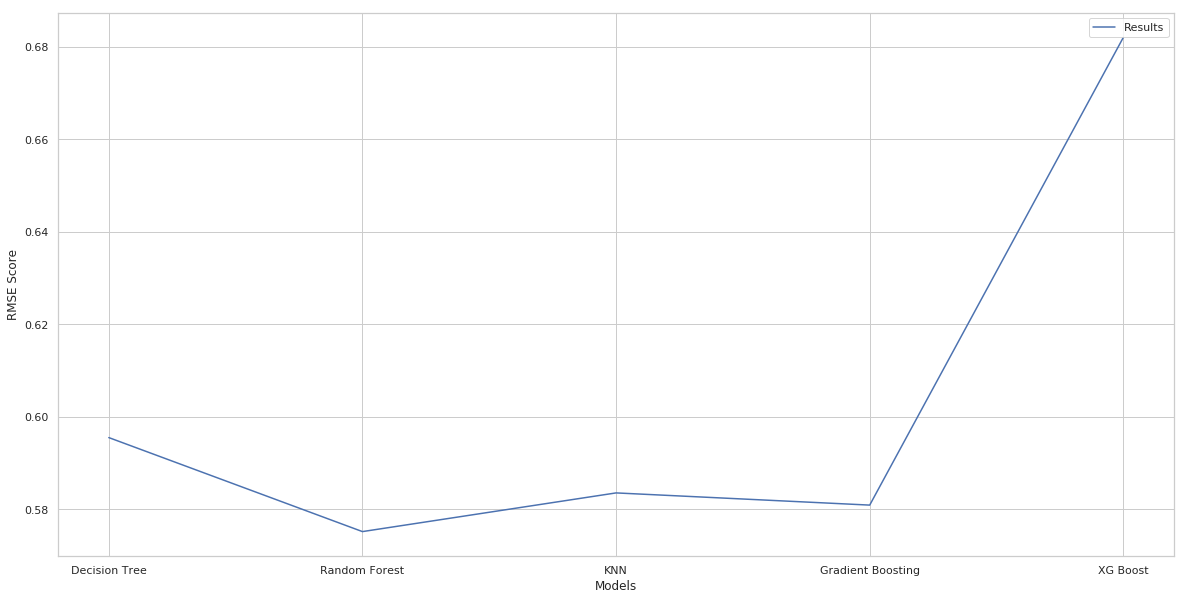

In [69]:
# boxplot algorithm comparison

df.plot(kind = 'line') 
plt.ylabel('RMSE Score')
plt.xlabel('Models')
plt.xticks(np.arange(5),labels = Regressors)
plt.show()

In [70]:
# performance comparison stastically, using t-test
from scipy import stats
print(stats.ttest_rel(cv_results_RF, cv_results_DT))
print(stats.ttest_rel(cv_results_DT, cv_results_KNN))
print(stats.ttest_rel(cv_results_RF, cv_results_KNN))

Ttest_relResult(statistic=-13.666923800615335, pvalue=0.0053111405596796115)
Ttest_relResult(statistic=5.155010060610004, pvalue=0.03563149431812278)
Ttest_relResult(statistic=-2.6938665858951083, pvalue=0.11459311601253507)


**t-test Hypothesis testing for performance significance**

Objective 1. Performance of Random Forest is significantly different from that of Decision Tree
Objective 2. Performance of Decision Tree is significantly different from that of KNN
Objective 3. Performance of Random Forest is significantly different from that of KNN

Null hypothesis: H0

: The performance of Decision Tree & Random Forest is identical  Vs

Alternative hypothesis Ha

: The performance of Decision Tree & Random Forest is significantly different

At 95% confidence.

We observe a smaller p-value, than 0.05 for objective 1, which is our theshold value then we can reject the null hypothesis of identical performance of Decision Tree & Random Forest and accept the alternative hypothesis, which implies that the difference is significant. Thus we choose the model with lower RMSE as a better choice. In this case it is random forest. Likewise for objective 2 and 3, we can compare other two performances, which shows decision tree over K Nearest Neighbours, and random forest over K Nearest Neighbours, respectively. Thus, we can conclude that random forest outperforms decion tree and K Nearest Neighbours.

In [71]:
# performance comparison stastically, using Anova test
from scipy.stats import f_oneway
statistics, p_value = f_oneway(cv_results_RF, cv_results_DT, cv_results_KNN, cv_results_GB, cv_results_XG)
print('Statistics=%0.2f, p=%0.10f' % (statistics, p_value))
# interpret
alpha = 0.05
if p_value > alpha:
    print('The performance of all 5 regressors are identical (fail to reject H0)')
else:
    print('The performance of all 5 regressors are significantly different (reject H0)')

Statistics=313.79, p=0.0000000002
The performance of all 5 regressors are significantly different (reject H0)


**Anova-test Hypothesis testing for performance significance**

Null hypothesis: H0

: The performance of all 5 regressors are identical  Vs

Alternative hypothesis Ha

: The performance of all 5 regressors are significantly different

At 95% confidence.

We observe a smaller p-value, than 0.05, which is our theshold value then we can reject the null hypothesis of identical performance of all the models and accept the alternative hypothesis, which implies that the difference is significant. Thus we choose the model with lower RMSE as a better choice. In this case it is random forest. Thus, we can conclude that random forest outperforms decion tree and K Nearest Neighbours, Gradient Boosting and XG Boost.

# Model Deployment

Since, random forest regressor is the best model, thus we will select it for deploying to complete set of the data.

In [69]:
#spliting the training and testing data, keeping 20% for testing and rest for training. 

features_scaled_train, features_scaled_test, target_train, target_test = train_test_split(features_scaled_sample, target_sample, test_size = 0.20, random_state = 42) 

In [70]:
import joblib
from sklearn.metrics import mean_squared_error
joblib.dump(gs_pipe_RF.best_estimator_, 'best_rf.pkl', compress = 1)
Best_Model = joblib.load('best_rf.pkl')

target_test_pred = Best_Model.predict(features_scaled_test)
target_train_pred = Best_Model.predict(features_scaled_train)

# test error
print("test error: RMSE ",np.sqrt(mean_squared_error(target_test_pred, target_test)))

# training error
print("training error: RMSE ",np.sqrt(mean_squared_error(target_train_pred, target_train)))


test error: RMSE  0.5737632751304435
training error: RMSE  0.5465159646760662


Now we will take 5 observation from the original dataset and then scale them and finally use our model to predict target variable for those observations.

In [71]:
RF_regressor_deployment = gs_pipe_RF.best_estimator_

# deploy the model on entire data
RF_regressor_deployment.fit(features_scaled, target)

# predict days_replaced for first 5 rows
prediction_feature = features.iloc[0:5, ]

# scale these observations using the standard scaler that was fitted to the input data
prediction = scaler.transform(prediction_feature)

# use the model's predict function for making a prediction for these five observations
final_prediction = RF_regressor_deployment.predict(prediction)

# prediction will the logrithmic value, as we have taken the log of target variable. Following will inverse the prediction
# and round it off
10**final_prediction

array([24.86158297,  9.69608241,  9.51228307, 10.84984836, 22.17925889])

In [72]:
import pickle

with open('/Users/saurabh/Desktop/rf.pickle', 'wb') as model_pkl:
    pickle.dump(clf, model_pkl)

NameError: name 'clf' is not defined

# Limitation and proposed solution

Limited computational power has been one of the major challenge for this study, as hyperparameter tuning requires lots of computational power, not all the parameters have been explored. However, small dataset has been used to find best parameters, which serves the purpose but definitely can be considered as another limitation of this study.
Thirdly, not all the possible regressors have been tried to evalute the performace, which certainly limits the finding of the study.

# Summary
In this study for predicting days taken to return to the sport after an injury, we have applied 5 regressor using hyperparameter tuning with grid search, out of which, randaom forest performs best, with RMSE of 0.33 To confirm the performance, we also calculated RMSE 0.58, using cross validation, which validates our finding. In order to assure the statistical significance, we implemented paired t-test. Once we found the best model, we applied to the entire data, for which also splitted into test and train sets and we calculated RMSE for them, which comes to 0.723 for train data and 0.721 for test data. The cross validated RMSE for test and train data are very close, which confirms that, there is no overfitting present in the model building.  


# References

Jones E, Oliphant E, Peterson P, et al. SciPy: Open Source Scientific Tools for Python, 2001-, http://www.scipy.org/ [Accessed 2019-06-15].

Lichman, M. (2013). UCI Machine Learning Repository: Census Income Data Set [online]. Available at https://archive.ics.uci.edu/ml/datasets/adult [Accessed 2019-06-15]   

Eryk Lewinson. Explaining Feature Importance by example of a Random Forest, Feb 2011-,https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e [Accessed 2019-06-15].

Jason Brownlee. Feature Importance and Feature Selection With XGBoost in Python, August 31, 2016, https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/ [Accessed 2019-06-15].

Dr. Vural Aksakalli. Case study 1 Predicting Income Status(sample report), 2019, https://rmit.instructure.com/courses/50786/pages/python-resources [Accessed 2019-06-15].
